<a href="https://colab.research.google.com/github/Hakan1998/NYC-Taxi-Demand-Forecast/blob/main/PJ_Building_Digital_Twin_ipynb_(ongoing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import math
import scipy
import pickle
import warnings
import datetime
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pylab as plt
import folium
import dask.dataframe as dd
import pandas as pd
import pyarrow.parquet as pq
import io
import requests
import gdown
from matplotlib import rcParams
from tqdm import tqdm
import time
from prettytable import PrettyTable
from datetime import datetime as d
import pyarrow.parquet as pq
import pandas as pd
import pandas.plotting as pd_plotting
from google.colab import drive
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import geopandas as gpd
from pyproj import CRS

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.Data Preprocessing

clean duplicates and drop off uneccessary columns

*   clean duplicates and drop off uneccessary columns
*   adding the zones for the Start and End zone to each Trip via NYC shapefile, same as in the Forecast but this time the end zone is also needed
+ Data: Training Data from January 2009


In [ ]:
parquet_path_2009 = "/content/drive/MyDrive/Projektseminar/yellow_tripdata_2009-01.parquet"
data_train = pq.read_table(parquet_path_2009).to_pandas()

def clean_duplicates(df):
    return df.drop_duplicates(keep='first')

# Clean duplicates
data_train = clean_duplicates(data_train)

# Liste der zu behaltenden Spalten
columns_to_keep = ['Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime', 'Start_Lon', 'Start_Lat', 'End_Lon', 'End_Lat']

# Entfernen Sie die Spalten, die nicht in der Liste enthalten sind
data_train = data_train[columns_to_keep]

display(data_train)

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Start_Lon,Start_Lat,End_Lon,End_Lat
0,2009-01-04 02:52:00,2009-01-04 03:02:00,-73.991957,40.721567,-73.993803,40.695922
1,2009-01-04 03:31:00,2009-01-04 03:38:00,-73.982102,40.736290,-73.955850,40.768030
2,2009-01-03 15:43:00,2009-01-03 15:57:00,-74.002587,40.739748,-73.869983,40.770225
3,2009-01-01 20:52:58,2009-01-01 21:14:00,-73.974267,40.790955,-73.996558,40.731849
4,2009-01-24 16:18:23,2009-01-24 16:24:56,-74.001580,40.719382,-74.008378,40.720350
...,...,...,...,...,...,...
14092408,2009-01-27 14:36:00,2009-01-27 14:46:00,-73.982013,40.743330,-73.994328,40.750130
14092409,2009-01-27 13:56:00,2009-01-27 14:02:00,-73.972788,40.761988,-73.951477,40.778217
14092410,2009-01-23 08:39:44,2009-01-23 09:02:15,-73.977467,40.751861,-74.009913,40.713470
14092411,2009-01-24 23:05:00,2009-01-24 23:15:00,-73.981295,40.753000,-73.949453,40.779520


creating GetdataFrames and doing the spatial join with New York City shapefile to add the zone for each Start and End Zone

In [ ]:
import pandas as pd
import geopandas as gpd
from fiona.crs import CRS


# Laden der Zonen-Shapefile und Setzen des Koordinatensystems
shapefile_path = "/content/drive/MyDrive/Projektseminar/taxi_zones/taxi_zones.shp"
gdf_zones = gpd.read_file(shapefile_path)
gdf_zones = gdf_zones.to_crs('EPSG:4326')

data_train.index = range(1, len(data_train) + 1)

# Vorbereitung der Datums-Zeit-Spalten für Abhol- und Absetzvorgänge
data_train['pickup_datetime'] = pd.to_datetime(data_train['Trip_Pickup_DateTime'])
data_train['dropoff_datetime'] = pd.to_datetime(data_train['Trip_Dropoff_DateTime'])

# Auswahl erforderlicher Spalten für Start- und Endzone
data_start = data_train[["pickup_datetime", "Start_Lon", "Start_Lat"]]
data_end = data_train[["dropoff_datetime", "End_Lon", "End_Lat"]]

# Erstellen eines GeoDataFrames für Start- und Endzonen
gdf_start = gpd.GeoDataFrame(data_start, geometry=gpd.points_from_xy(data_start['Start_Lon'], data_start['Start_Lat']))
gdf_end = gpd.GeoDataFrame(data_end, geometry=gpd.points_from_xy(data_end['End_Lon'], data_end['End_Lat']))

# Setzen des Koordinatensystems für GeoDataFrames
gdf_start.crs = CRS.from_epsg(4326)
gdf_end.crs = CRS.from_epsg(4326)

# Räumlicher Join für Startzonen
taxi_with_start_zones = gpd.sjoin(gdf_start, gdf_zones, how='left', op='within')
taxi_with_start_zones = taxi_with_start_zones.rename(columns={"zone": "start_zone", "borough":"start_borough" })

# Räumlicher Join für Endzonen
taxi_with_end_zones = gpd.sjoin(gdf_end, gdf_zones, how='left', op='within')
taxi_with_end_zones = taxi_with_end_zones.rename(columns={'zone': 'end_zone', "borough":"end_borough"})

# Merging basierend auf dem Index von data_train
result = pd.merge(data_train, taxi_with_start_zones[['start_borough', 'start_zone']], left_index=True, right_index=True)
result = pd.merge(result, taxi_with_end_zones[["end_zone", "end_borough"]], left_index=True, right_index=True)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
display(result)

,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Start_Lon,Start_Lat,End_Lon,End_Lat,pickup_datetime,dropoff_datetime,start_borough,start_zone,end_zone,end_borough
1,2009-01-04 02:52:00,2009-01-04 03:02:00,-73.991957,40.721567,-73.993803,40.695922,2009-01-04 02:52:00,2009-01-04 03:02:00,Manhattan,Lower East Side,Brooklyn Heights,Brooklyn
2,2009-01-04 03:31:00,2009-01-04 03:38:00,-73.982102,40.736290,-73.955850,40.768030,2009-01-04 03:31:00,2009-01-04 03:38:00,Manhattan,Gramercy,Lenox Hill West,Manhattan
3,2009-01-03 15:43:00,2009-01-03 15:57:00,-74.002587,40.739748,-73.869983,40.770225,2009-01-03 15:43:00,2009-01-03 15:57:00,Manhattan,West Village,East Elmhurst,Queens
4,2009-01-01 20:52:58,2009-01-01 21:14:00,-73.974267,40.790955,-73.996558,40.731849,2009-01-01 20:52:58,2009-01-01 21:14:00,Manhattan,Upper West Side North,Greenwich Village North,Manhattan
5,2009-01-24 16:18:23,2009-01-24 16:24:56,-74.001580,40.719382,-74.008378,40.720350,2009-01-24 16:18:23,2009-01-24 16:24:56,Manhattan,Little Italy/NoLiTa,TriBeCa/Civic Center,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...
14092378,2009-01-27 14:36:00,2009-01-27 14:46:00,-73.982013,40.743330,-73.994328,40.750130,2009-01-27 14:36:00,2009-01-27 14:46:00,Manhattan,Murray Hill,Penn Station/Madison Sq West,Manhattan
14092379,2009-01-27 13:56:00,2009-01-27 14:02:00,-73.972788,40.761988,-73.951477,40.778217,2009-01-27 13:56:00,2009-01-27 14:02:00,Manhattan,Midtown North,Yorkville West,Manhattan
14092380,2009-01-23 08:39:44,2009-01-23 09:02:15,-73.977467,40.751861,-74.009913,40.713470,2009-01-23 08:39:44,2009-01-23 09:02:15,Manhattan,Murray Hill,TriBeCa/Civic Center,Manhattan
14092381,2009-01-24 23:05:00,2009-01-24 23:15:00,-73.981295,40.753000,-73.949453,40.779520,2009-01-24 23:05:00,2009-01-24 23:15:00,Manhattan,Midtown South,Yorkville West,Manhattan


now count Trips for each Origin Destiny combination of each Hour and each zone andf ilter to Manhatten only

In [ ]:

selected_columns = ["Trip_Pickup_DateTime", "Trip_Dropoff_DateTime", "start_zone", "end_zone"]
od_data = result[(result['start_borough'] == 'Manhattan') & (result['end_borough'] == 'Manhattan')][selected_columns].reset_index(drop=True)

# Konvertieren Sie die Zeitdaten in das Datetime-Format
od_data['Trip_Pickup_DateTime'] = pd.to_datetime(od_data['Trip_Pickup_DateTime'])

# Extrahieren Sie die Stunde und kombinieren Sie Datum und Stunde
od_data['DateTime'] = od_data['Trip_Pickup_DateTime'].dt.strftime('%Y-%m-%d %H:00:00')

# Gruppieren Sie nach Start- und Endzone, kombiniertem Datum und Stunde und zählen Sie die Anzahl der Fahrten
hourly_trip_counts = od_data.groupby(['start_zone', 'end_zone', 'DateTime']).size().reset_index(name='Trips')

# Anzeigen der erstellten Tabelle
print("Stündliche Anzahl der Trips für jede Start-Ziel-Kombination im Zeitverlauf:")
display(hourly_trip_counts)

Stündliche Anzahl der Trips für jede Start-Ziel-Kombination im Zeitverlauf:


,start_zone,end_zone,DateTime,Trips
0,Alphabet City,Alphabet City,2009-01-01 00:00:00,4
1,Alphabet City,Alphabet City,2009-01-01 01:00:00,6
2,Alphabet City,Alphabet City,2009-01-01 02:00:00,2
3,Alphabet City,Alphabet City,2009-01-01 03:00:00,7
4,Alphabet City,Alphabet City,2009-01-01 04:00:00,6
...,...,...,...,...
1603086,Yorkville West,Yorkville West,2009-01-31 19:00:00,56
1603087,Yorkville West,Yorkville West,2009-01-31 20:00:00,50
1603088,Yorkville West,Yorkville West,2009-01-31 21:00:00,45
1603089,Yorkville West,Yorkville West,2009-01-31 22:00:00,47


this is the Table we should work with from now

#  2.Origin Destiny weight Matrix (no Time Binning)

We first look at the Distribution as a whole without considering the time
Create a cross Table so see how many Trips when from which zone to which zone in Manhatten

In [ ]:
df = hourly_trip_counts
# Erstelle eine Kreuztabelle mit der Anzahl der Trips

# absolute trip values
cross_table = pd.crosstab(df['start_zone'], df['end_zone'], values=df['Trips'], aggfunc='sum', margins=True, margins_name='Gesamt')

# procent distribution of trips from one zone to another
cross_table_percent = cross_table.div(cross_table['Gesamt'], axis=0)

print("\nProzentuale Verteilung:")
display(cross_table_percent)


Prozentuale Verteilung:


end_zone,Alphabet City,Battery Park,Battery Park City,Bloomingdale,Central Harlem,Central Harlem North,Central Park,Chinatown,Clinton East,Clinton West,...,Upper West Side North,Upper West Side South,Washington Heights North,Washington Heights South,West Chelsea/Hudson Yards,West Village,World Trade Center,Yorkville East,Yorkville West,Gesamt
start_zone,,,,,,,,,,,,,,,,,,,,,
Alphabet City,0.039023,0.000245,0.006457,0.001837,0.002975,0.002065,0.002747,0.008172,0.015452,0.004620,...,0.004760,0.006597,0.001592,0.001662,0.011112,0.033493,0.004865,0.006265,0.012372,1.0
Battery Park,0.006252,0.012503,0.053619,0.000481,0.000240,0.000240,0.014186,0.024285,0.022121,0.007935,...,0.002404,0.010099,0.000721,0.000721,0.014667,0.014186,0.045203,0.003366,0.003366,1.0
Battery Park City,0.005513,0.007667,0.040417,0.000843,0.000830,0.000867,0.004273,0.009930,0.021822,0.007535,...,0.006656,0.009906,0.000614,0.001408,0.022760,0.032847,0.019246,0.004550,0.006644,1.0
Bloomingdale,0.001979,0.000269,0.002052,0.029635,0.040116,0.016027,0.020083,0.000757,0.024773,0.007623,...,0.121864,0.101317,0.005839,0.017517,0.008820,0.006035,0.000806,0.010017,0.018153,1.0
Central Harlem,0.001841,0.000072,0.001119,0.031077,0.114817,0.045335,0.022090,0.000794,0.025772,0.006317,...,0.056741,0.043711,0.004945,0.011189,0.007038,0.005486,0.000866,0.007869,0.018264,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Village,0.009870,0.000476,0.013838,0.001469,0.002094,0.001602,0.004657,0.004340,0.023731,0.006954,...,0.006696,0.010323,0.001379,0.002023,0.021621,0.055209,0.007239,0.004932,0.008776,1.0
World Trade Center,0.007624,0.003605,0.031379,0.001164,0.001183,0.001202,0.005577,0.015229,0.021426,0.006723,...,0.005314,0.008037,0.000958,0.001239,0.021201,0.033557,0.029369,0.005014,0.007530,1.0
Yorkville East,0.003066,0.000142,0.003614,0.002605,0.003762,0.002371,0.016515,0.001170,0.011921,0.002882,...,0.023257,0.026324,0.001385,0.002617,0.004206,0.006293,0.001502,0.044205,0.057031,1.0


In [ ]:
print(cross_table_percent.head(0))

Empty DataFrame
Columns: [Alphabet City, Battery Park, Battery Park City, Bloomingdale, Central Harlem, Central Harlem North, Central Park, Chinatown, Clinton East, Clinton West, East Chelsea, East Harlem North, East Harlem South, East Village, Financial District North, Financial District South, Flatiron, Garment District, Governor's Island/Ellis Island/Liberty Island, Gramercy, Greenwich Village North, Greenwich Village South, Hamilton Heights, Highbridge Park, Hudson Sq, Inwood, Inwood Hill Park, Kips Bay, Lenox Hill East, Lenox Hill West, Lincoln Square East, Lincoln Square West, Little Italy/NoLiTa, Lower East Side, Manhattan Valley, Manhattanville, Marble Hill, Meatpacking/West Village West, Midtown Center, Midtown East, Midtown North, Midtown South, Morningside Heights, Murray Hill, Penn Station/Madison Sq West, Randalls Island, Roosevelt Island, Seaport, SoHo, Stuy Town/Peter Cooper Village, Sutton Place/Turtle Bay North, Times Sq/Theatre District, TriBeCa/Civic Center, Two Brid

Right here we can see the Distribution of all origin Destiny trips in each zone.

About ~ 4% of all pickups in Alphabet City went back to this same zone.

Further 0.03% of pickups from Alphabet city went to Battery Park and so on.

**Boxplot for the OD Distribution. **

This is important to check if we have zones which dont do OD Trips and maybe have naturally only zone intern Trips.


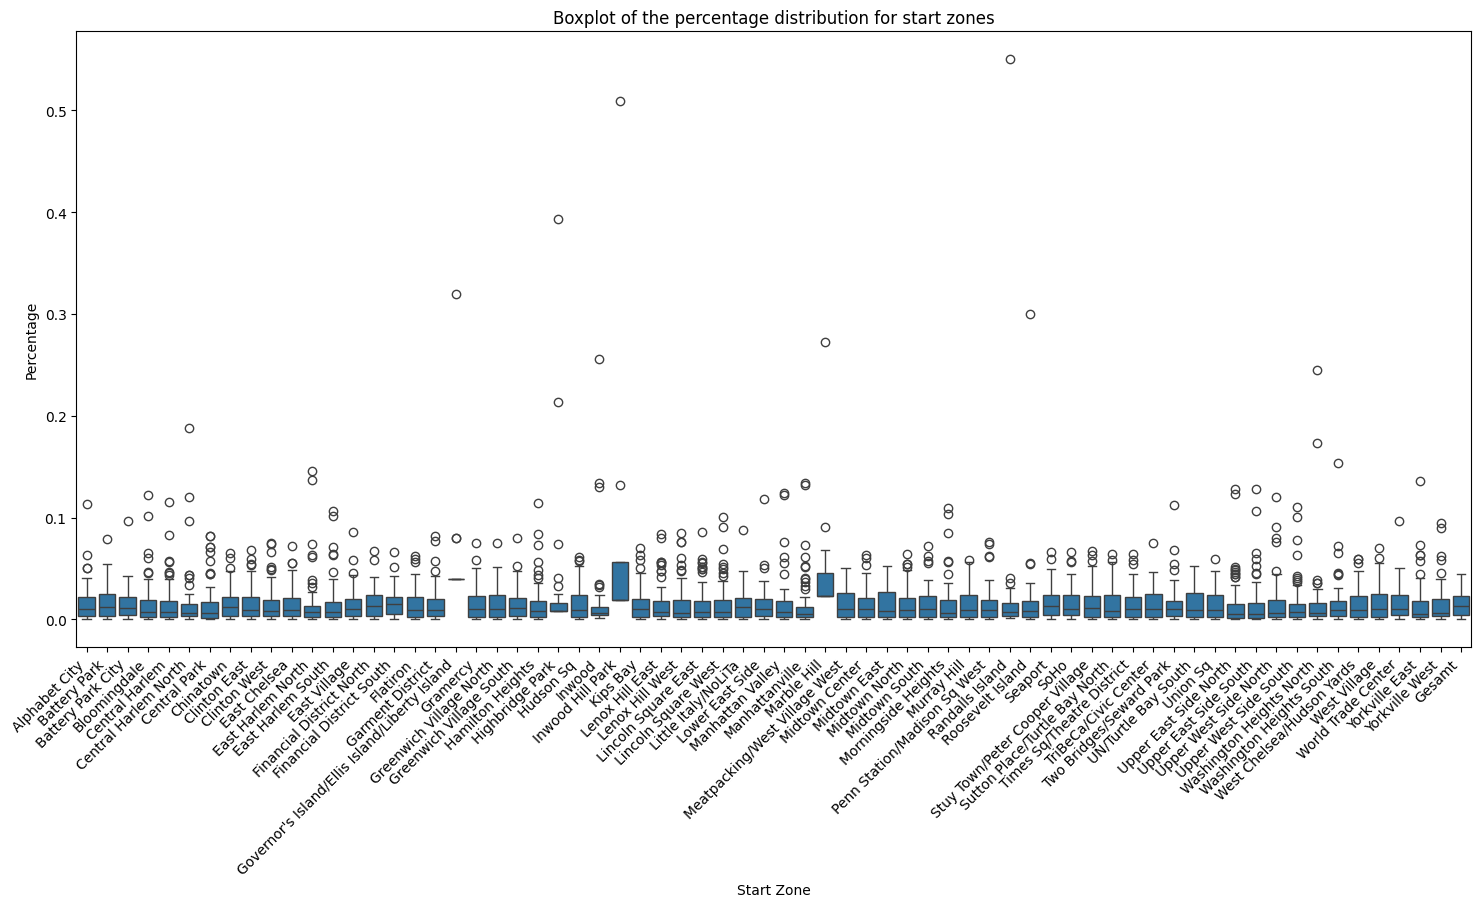

In [ ]:
data = cross_table_percent

# Filtern Sie die Daten, um die letzte Spalte ("Gesamt") zu entfernen
filtered_data = data.iloc[:, :-1]

# Melt the DataFrame to long format for easy plotting
melted_data = pd.melt(filtered_data.transpose(), var_name='Start Zone', value_name='Percentage')

# Erstellen Sie einen Boxplot
plt.figure(figsize=(18, 8))
sns.boxplot(x='Start Zone', y='Percentage', data=melted_data)
plt.title('Boxplot of the percentage distribution for start zones')
plt.xticks(rotation=45, ha='right')
plt.show()

As we can see 3 zones have zone End zone "outliners" where all the Trips going. Otherwise, most zones have a relatively even distribution, which suggests that the trips run into different end zones.


Now lets visulize 4 zones with the most trips and the 2 biggest outliers.

**Info: Red zone is also the end/start zone.** All Other blue zone are end zones.



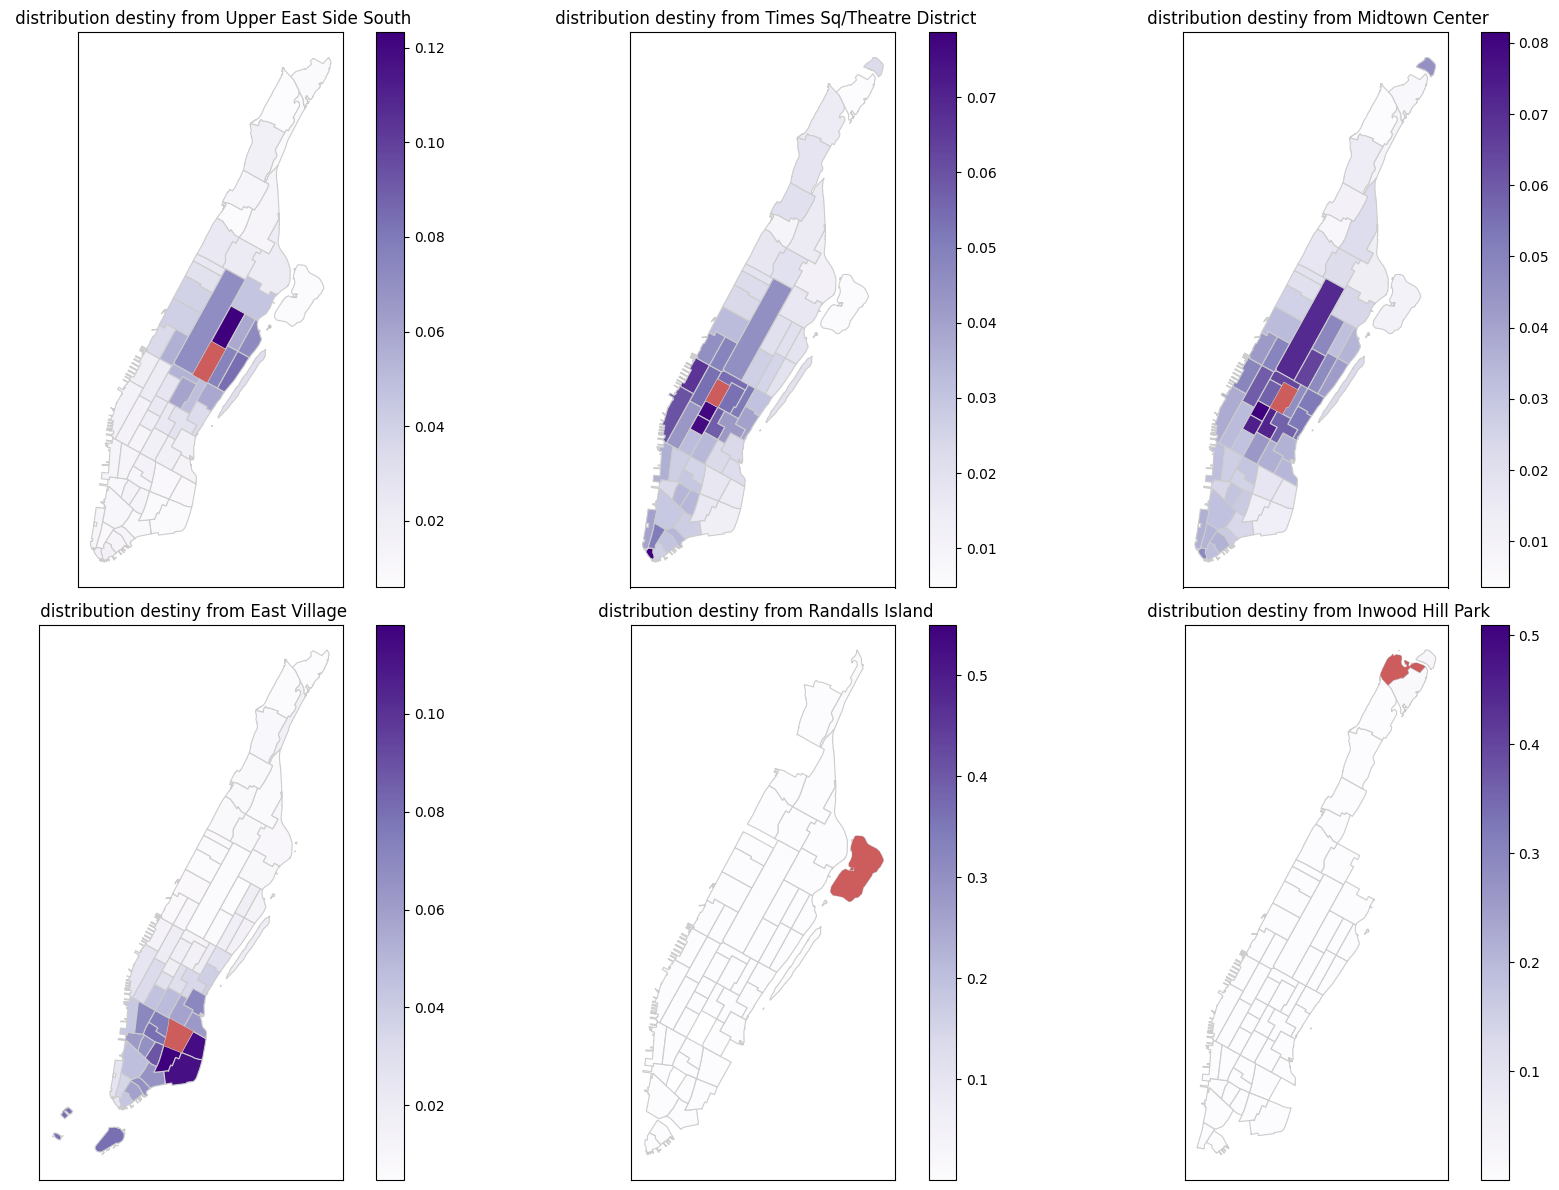

In [ ]:
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

data = cross_table_percent
shapefile_path = "/content/drive/MyDrive/Projektseminar/taxi_zones/taxi_zones.shp"
zones_gdf = gpd.read_file(shapefile_path)


# Wählen Sie die Zonen aus, die Sie visualisieren möchten
selected_zones = ['Upper East Side South', 'Times Sq/Theatre District', 'Midtown Center', 'East Village', 'Randalls Island', 'Inwood Hill Park']



# Transponieren Sie die Daten für eine bessere Darstellung in der Karte
transposed_data = data.T * 100

# Fügen Sie die Koordinaten aus der Shapefile hinzu
zones_gdf = zones_gdf.merge(data, left_on='zone', right_index=True)

# Erstellen Sie eine Choroplethenkarte für jede ausgewählte Zone
fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw={'aspect': 'equal'})
axes = axes.flatten()

for i, zone in enumerate(selected_zones):
    zones_gdf.plot(column=zone, cmap='Purples', linewidth=0.8, ax=axes[i], edgecolor='0.8', legend=True)
    axes[i].set_title(f' distribution destiny from {zone}')

    # Markieren Sie die Startzone, die auch als Endzone verwendet wird, in rot
    start_end_zone = zones_gdf[zones_gdf['zone'] == zone]
    start_end_zone.plot(ax=axes[i], color='indianred', markersize=50, label=zone)

    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()
plt.show()

Info: Red zone is also the end/start zone. All Other blue zone are end zones.

As we can see, most end zones are logically the surrounding zones of a start zone.  Only a few zones have mainly zone internal trips.




# 3.OD Constancy over Time and OD Combination

Now lets also consider the Day and the Hour to get a more realistic OD Matrix.
After we create the OD Matrix we want to check if the Distribution is constant over time and OD Combinations. To do this we simply create a Heapmap of the standard deviations.


In [ ]:
df = hourly_trip_counts
# Extrahiere die Stunden des Tages und die Tage des Monats aus der DateTime-Spalte
df['Hour'] = pd.to_datetime(df['DateTime']).dt.hour
df['Day'] = pd.to_datetime(df['DateTime']).dt.day

# Erstelle eine Kreuztabelle mit der Anzahl der Trips, gruppiert nach Tagen und Stunden
cross_table_daily_hourly = pd.crosstab([df['start_zone'], df['Day'], df['Hour']], df['end_zone'], values=df['Trips'], aggfunc='sum', margins=True, margins_name='Gesamt')

# Ersetze NaN-Werte durch 0
cross_table_daily_hourly = cross_table_daily_hourly.fillna(0)

# Berechne die prozentualen Werte
cross_table_daily_hourly_percent = cross_table_daily_hourly.div(cross_table_daily_hourly['Gesamt'], axis=0)

# Ausgabe der Kreuztabelle mit prozentualen Werten
display(cross_table_daily_hourly_percent)

end_zone                 Alphabet City  Battery Park  Battery Park City  \
start_zone     Day Hour                                                   
Alphabet City  1   0          0.040000      0.000000           0.010000   
                   1          0.048780      0.000000           0.008130   
                   2          0.018182      0.000000           0.000000   
                   3          0.071429      0.000000           0.020408   
                   4          0.075000      0.000000           0.000000   
...                                ...           ...                ...   
Yorkville West 31  20         0.003774      0.000000           0.000000   
                   21         0.004831      0.000000           0.000000   
                   22         0.007362      0.000000           0.002454   
                   23         0.007692      0.000000           0.001538   
Gesamt                        0.006157      0.000533           0.008204   

end_zone                 Bloomingdale  Central Harlem  Central Harlem North  \
start_zone     Day Hour                                                       
Alphabet City  1   0         0.000000        0.000000              0.010000   
                   1         0.008130        0.000000              0.008130   
                   2         0.009091        0.000000              0.000000   
                   3         0.000000        0.040816              0.010204   
                   4         0.012500        0.000000              0.000000   
...                               ...             ...                   ...   
Yorkville West 31  20        0.007547        0.002516              0.001258   
                   21        0.009662        0.001208              0.003623   
                   22        0.001227        0.008589              0.003681   
                   23        0.004615        0.013846              0.000000   
Gesamt                       0.003632        0.004577              0.003059   

end_zone                 Central Park  Chinatown  Clinton East  Clinton West  \
start_zone     Day Hour                                                        
Alphabet City  1   0         0.010000   0.000000      0.060000      0.000000   
                   1         0.008130   0.008130      0.016260      0.000000   
                   2         0.000000   0.009091      0.009091      0.009091   
                   3         0.000000   0.000000      0.010204      0.000000   
                   4         0.012500   0.000000      0.025000      0.025000   
...                               ...        ...           ...           ...   
Yorkville West 31  20        0.011321   0.002516      0.016352      0.002516   
                   21        0.012077   0.000000      0.031401      0.001208   
                   22        0.004908   0.000000      0.011043      0.006135   
                   23        0.004615   0.000000      0.026154      0.006154   
Gesamt                       0.013362   0.002920      0.028282      0.010007   

end_zone                 ...  Upper West Side North  Upper West Side South  \
start_zone     Day Hour  ...                                                 
Alphabet City  1   0     ...               0.000000               0.020000   
                   1     ...               0.008130               0.016260   
                   2     ...               0.009091               0.009091   
                   3     ...               0.000000               0.010204   
                   4     ...               0.025000               0.012500   
...                      ...                    ...                    ...   
Yorkville West 31  20    ...               0.022642               0.031447   
                   21    ...               0.026570               0.035024   
                   22    ...               0.029448               0.029448   
                   23    ...               0.026154               0.047692   
Gesamt             

In [ ]:


# Berechnung der Standardabweichung über die Stunden für jede Zone-Kombination
std_dev_per_zone_combo = cross_table_daily_hourly_percent.groupby(level='start_zone').std()

# Berechnung der Standardabweichung über die Zonen für jede Stunde
std_dev_per_hour = cross_table_daily_hourly_percent.groupby(level='Hour').std()


print("\nStandardabweichungen über die Zonen für jede OD Kombi:")
display(std_dev_per_zone_combo)


print("\nStandardabweichungen über die Zonen für jede Stunde:")
display(std_dev_per_hour)



Standardabweichungen über die Zonen für jede OD Kombi:


end_zone,Alphabet City,Battery Park,Battery Park City,Bloomingdale,Central Harlem,Central Harlem North,Central Park,Chinatown,Clinton East,Clinton West,...,Upper West Side North,Upper West Side South,Washington Heights North,Washington Heights South,West Chelsea/Hudson Yards,West Village,World Trade Center,Yorkville East,Yorkville West,Gesamt
start_zone,,,,,,,,,,,,,,,,,,,,,
Alphabet City,0.033780,0.001541,0.010818,0.005699,0.008092,0.006833,0.007261,0.013058,0.021800,0.011296,...,0.009809,0.011672,0.009277,0.008369,0.014039,0.023215,0.008559,0.010741,0.017193,0.0
Battery Park,0.067681,0.065810,0.153678,0.008383,0.001551,0.013962,0.029469,0.070947,0.078083,0.037835,...,0.036151,0.041566,0.030176,0.044141,0.120839,0.094183,0.115865,0.061912,0.054345,0.0
Battery Park City,0.019008,0.008348,0.063410,0.010819,0.011675,0.021393,0.009442,0.015053,0.029161,0.018365,...,0.032592,0.020197,0.006043,0.014307,0.025005,0.030528,0.026120,0.020762,0.024169,0.0
Bloomingdale,0.007026,0.003563,0.006787,0.033455,0.044711,0.026821,0.022397,0.004372,0.029001,0.019657,...,0.060132,0.053261,0.023363,0.033358,0.017929,0.014193,0.005263,0.017296,0.023604,0.0
Central Harlem,0.007479,0.001457,0.013123,0.034595,0.085782,0.064758,0.047976,0.005704,0.032950,0.017563,...,0.043904,0.038118,0.018056,0.029501,0.018493,0.014131,0.011003,0.018464,0.024323,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Chelsea/Hudson Yards,0.008064,0.002336,0.017830,0.004936,0.009126,0.010097,0.010283,0.004402,0.027427,0.020853,...,0.012477,0.014994,0.006568,0.011197,0.038848,0.018355,0.007190,0.008223,0.011413,0.0
West Village,0.008183,0.001639,0.009424,0.002999,0.005502,0.005535,0.006810,0.005704,0.014201,0.005569,...,0.006428,0.008008,0.003909,0.005124,0.015818,0.021866,0.006341,0.005642,0.007883,0.0
World Trade Center,0.016230,0.009338,0.031756,0.016959,0.014756,0.011047,0.012975,0.018819,0.029054,0.025894,...,0.015938,0.018497,0.007602,0.012881,0.031501,0.042445,0.058830,0.013376,0.021028,0.0



Standardabweichungen über die Zonen für jede Stunde:


end_zone,Alphabet City,Battery Park,Battery Park City,Bloomingdale,Central Harlem,Central Harlem North,Central Park,Chinatown,Clinton East,Clinton West,...,Upper West Side North,Upper West Side South,Washington Heights North,Washington Heights South,West Chelsea/Hudson Yards,West Village,World Trade Center,Yorkville East,Yorkville West,Gesamt
Hour,,,,,,,,,,,,,,,,,,,,,
0,0.019521,0.011698,0.025336,0.032014,0.033418,0.048595,0.029571,0.026469,0.033245,0.018589,...,0.053263,0.030277,0.057112,0.075093,0.044076,0.024145,0.034510,0.024537,0.034070,0.0
1,0.027788,0.001981,0.025074,0.025950,0.048528,0.049873,0.020116,0.018551,0.039581,0.019801,...,0.036353,0.035387,0.049157,0.073248,0.025704,0.036583,0.014424,0.040343,0.041615,0.0
2,0.026853,0.004184,0.031773,0.027049,0.049488,0.072608,0.038638,0.016979,0.044306,0.023755,...,0.045328,0.034642,0.076824,0.077740,0.022539,0.032232,0.023607,0.038494,0.044686,0.0
3,0.028100,0.008395,0.035426,0.026967,0.062525,0.071501,0.037845,0.022945,0.051806,0.028305,...,0.043894,0.032193,0.089294,0.067630,0.019778,0.037834,0.026232,0.033037,0.045552,0.0
4,0.033497,0.011834,0.034081,0.040999,0.060318,0.076471,0.034301,0.028328,0.056036,0.042922,...,0.060435,0.036218,0.055006,0.086573,0.030846,0.029390,0.057038,0.040150,0.046422,0.0
5,0.031808,0.023527,0.039497,0.028043,0.041071,0.046278,0.019832,0.018433,0.046544,0.034632,...,0.049750,0.034796,0.068295,0.075499,0.028749,0.027583,0.026770,0.037110,0.030493,0.0
6,0.017715,0.002472,0.052508,0.018694,0.025497,0.043536,0.038940,0.021738,0.047309,0.041494,...,0.032183,0.035867,0.051221,0.077957,0.043994,0.022354,0.022937,0.030838,0.019208,0.0
7,0.016356,0.007401,0.042431,0.011317,0.027654,0.028281,0.038030,0.014527,0.030806,0.025253,...,0.046843,0.037303,0.056570,0.060879,0.046506,0.030357,0.023008,0.016084,0.030786,0.0
8,0.013212,0.015107,0.032273,0.011549,0.029965,0.031957,0.044378,0.018744,0.025690,0.034200,...,0.044527,0.046478,0.050299,0.065699,0.056751,0.022801,0.015768,0.014271,0.030985,0.0


**Note**: for better readability only every 3rd zone ins showed on both axis in. the following graphs.

---



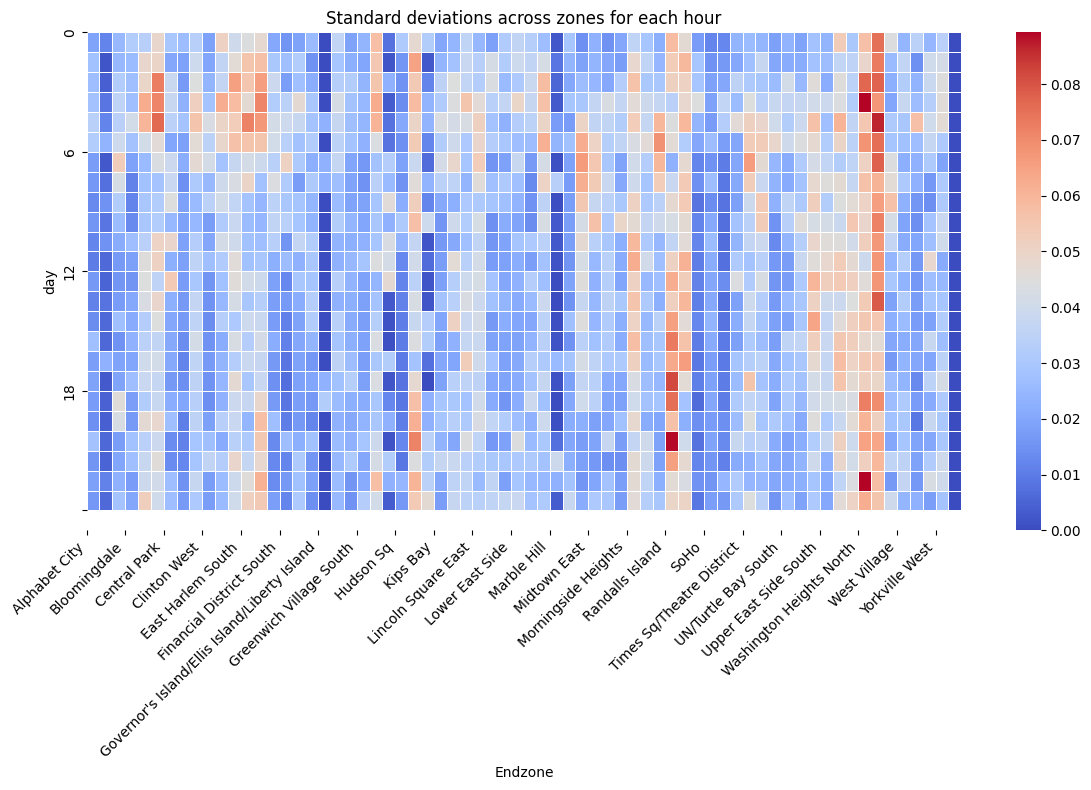

In [ ]:
# Berechnung der Standardabweichung über die Zonen für jede Stunde
std_dev_per_hour = cross_table_daily_hourly_percent.groupby(level='Hour').std()

plt.figure(figsize=(12, 8))
sns.heatmap(std_dev_per_hour, cmap='coolwarm', annot=False, fmt=".3f", linewidths=.5)
plt.title('Standard deviations across zones for each hour')
plt.xlabel('Endzone')
plt.ylabel('day')

# Nur jeden 6. Wert auf der y-Achse anzeigen
plt.yticks(ticks=range(0, len(std_dev_per_hour.index), 6), labels=std_dev_per_hour.index[::6])

plt.xticks(ticks=range(0, len(std_dev_per_hour.columns), 3), labels=std_dev_per_hour.columns[::3], rotation=45, ha='right')
plt.tight_layout()
plt.show()


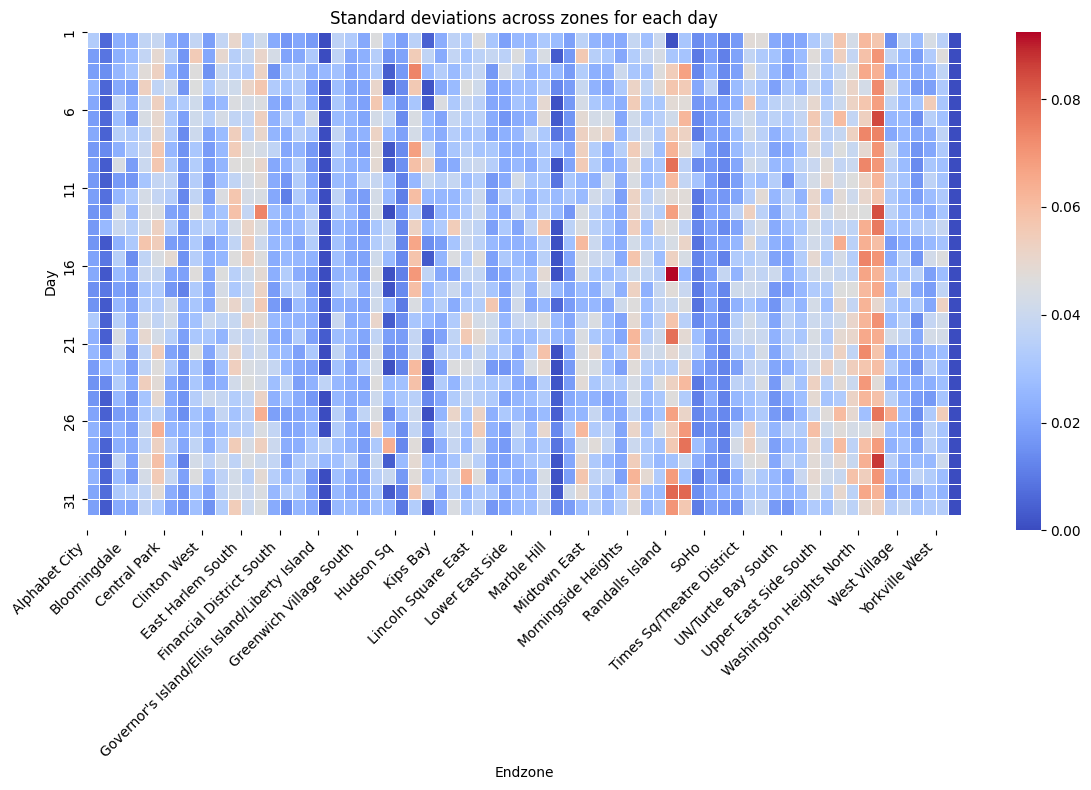

In [ ]:
# Berechnung der Standardabweichung über die Zonen für jede Stunde
std_dev_per_day = cross_table_daily_hourly_percent.groupby(level='Day').std()

plt.figure(figsize=(12, 8))
sns.heatmap(std_dev_per_day, cmap='coolwarm', annot=False, fmt=".3f", linewidths=.5)
plt.title('Standard deviations across zones for each day')
plt.xlabel('Endzone')
plt.ylabel('Day')

# Nur jeden 5. Wert auf der y-Achse anzeigen
plt.yticks(ticks=range(0, len(std_dev_per_day.index), 5), labels=std_dev_per_day.index[::5])

plt.xticks(ticks=range(0, len(std_dev_per_day.columns), 3), labels=std_dev_per_day.columns[::3], rotation=45, ha='right')
plt.tight_layout()
plt.show()


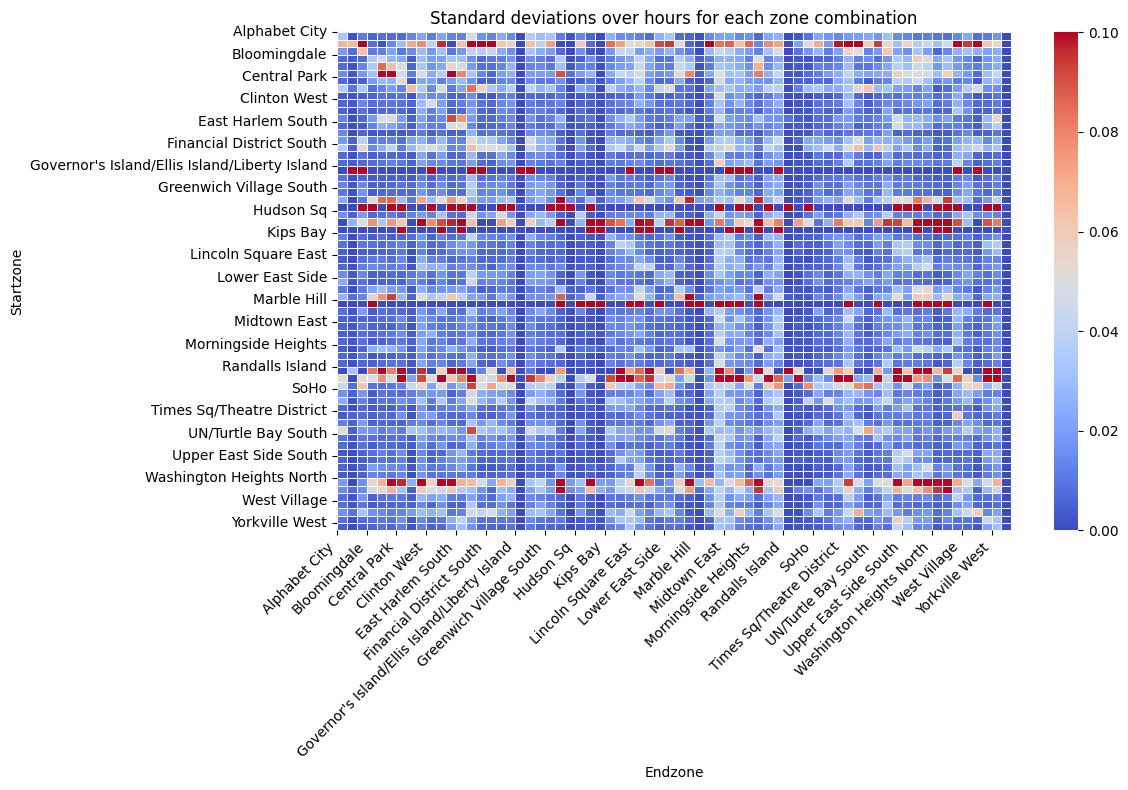

In [ ]:
# Erstellen der Heatmap für die Standardabweichungen über die Stunden für jede Zone-Kombination
#std_dev_per_zone_combo.drop(index='Gesamt', inplace=True)


plt.figure(figsize=(12, 8))
sns.heatmap(std_dev_per_zone_combo, cmap='coolwarm', annot=False, fmt=".3f", linewidths=.5, vmin=0, vmax=0.1)
plt.title('Standard deviations over hours for each zone combination')
plt.xlabel('Endzone')
plt.ylabel('Startzone')
plt.xticks(ticks=range(0, len(std_dev_per_zone_combo.columns), 3), labels=std_dev_per_zone_combo.columns[::3], rotation=45, ha='right')
plt.yticks(ticks=range(0, len(std_dev_per_zone_combo.columns), 3), labels=std_dev_per_zone_combo.columns[::3], ha='right')
plt.tight_layout()
plt.show()

# 4.Digital Twin

load Forecast

In [ ]:
ProphetForecast_path_train = '/content/drive/My Drive/Projektseminar/PROPHET_Forecast_allZones.parquet'
Forecast_data = pd.read_parquet(ProphetForecast_path_train)

forecast = Forecast_data.loc[:, ['ds', 'forecast_best', 'Zone']]
print(forecast)


                       ds  forecast_best            Zone
0     2009-01-31 23:00:00            158   Alphabet City
1     2009-02-01 00:00:00            166   Alphabet City
2     2009-02-01 01:00:00            167   Alphabet City
3     2009-02-01 02:00:00            153   Alphabet City
4     2009-02-01 03:00:00            125   Alphabet City
...                   ...            ...             ...
45019 2009-02-28 18:00:00            704  Yorkville West
45020 2009-02-28 19:00:00            737  Yorkville West
45021 2009-02-28 20:00:00            735  Yorkville West
45022 2009-02-28 21:00:00            704  Yorkville West
45023 2009-02-28 22:00:00            661  Yorkville West

[45024 rows x 3 columns]


In [ ]:
# Angenommen, hourly_trip_counts ist Ihr DataFrame
df = hourly_trip_counts

# Extrahiere die Stunden des Tages und die Tage des Monats aus der DateTime-Spalte
df['Hour'] = pd.to_datetime(df['DateTime']).dt.hour
df['Day'] = pd.to_datetime(df['DateTime']).dt.day

# Erstelle eine Kreuztabelle mit der Anzahl der Trips, gruppiert nach Tagen, Stunden und end_zone
cross_table_daily_hourly = pd.crosstab([df['start_zone'], df['Day'], df['Hour']], df['end_zone'], values=df['Trips'], aggfunc='sum', margins=True, margins_name='Gesamt')

# Ersetze NaN-Werte durch 0
cross_table_daily_hourly = cross_table_daily_hourly.fillna(0)

# Berechne die prozentualen Werte
cross_table_daily_hourly_percent = cross_table_daily_hourly.div(cross_table_daily_hourly['Gesamt'], axis=0)
# Ausgabe der Kreuztabelle mit prozentualen Werten
display(cross_table_daily_hourly_percent)

end_zone                 Alphabet City  Battery Park  Battery Park City  \
start_zone     Day Hour                                                   
Alphabet City  1   0          0.040000      0.000000           0.010000   
                   1          0.048780      0.000000           0.008130   
                   2          0.018182      0.000000           0.000000   
                   3          0.071429      0.000000           0.020408   
                   4          0.075000      0.000000           0.000000   
...                                ...           ...                ...   
Yorkville West 31  20         0.003774      0.000000           0.000000   
                   21         0.004831      0.000000           0.000000   
                   22         0.007362      0.000000           0.002454   
                   23         0.007692      0.000000           0.001538   
Gesamt                        0.006157      0.000533           0.008204   

end_zone                 Bloomingdale  Central Harlem  Central Harlem North  \
start_zone     Day Hour                                                       
Alphabet City  1   0         0.000000        0.000000              0.010000   
                   1         0.008130        0.000000              0.008130   
                   2         0.009091        0.000000              0.000000   
                   3         0.000000        0.040816              0.010204   
                   4         0.012500        0.000000              0.000000   
...                               ...             ...                   ...   
Yorkville West 31  20        0.007547        0.002516              0.001258   
                   21        0.009662        0.001208              0.003623   
                   22        0.001227        0.008589              0.003681   
                   23        0.004615        0.013846              0.000000   
Gesamt                       0.003632        0.004577              0.003059   

end_zone                 Central Park  Chinatown  Clinton East  Clinton West  \
start_zone     Day Hour                                                        
Alphabet City  1   0         0.010000   0.000000      0.060000      0.000000   
                   1         0.008130   0.008130      0.016260      0.000000   
                   2         0.000000   0.009091      0.009091      0.009091   
                   3         0.000000   0.000000      0.010204      0.000000   
                   4         0.012500   0.000000      0.025000      0.025000   
...                               ...        ...           ...           ...   
Yorkville West 31  20        0.011321   0.002516      0.016352      0.002516   
                   21        0.012077   0.000000      0.031401      0.001208   
                   22        0.004908   0.000000      0.011043      0.006135   
                   23        0.004615   0.000000      0.026154      0.006154   
Gesamt                       0.013362   0.002920      0.028282      0.010007   

end_zone                 ...  Upper West Side North  Upper West Side South  \
start_zone     Day Hour  ...                                                 
Alphabet City  1   0     ...               0.000000               0.020000   
                   1     ...               0.008130               0.016260   
                   2     ...               0.009091               0.009091   
                   3     ...               0.000000               0.010204   
                   4     ...               0.025000               0.012500   
...                      ...                    ...                    ...   
Yorkville West 31  20    ...               0.022642               0.031447   
                   21    ...               0.026570               0.035024   
                   22    ...               0.029448               0.029448   
                   23    ...               0.026154               0.047692   
Gesamt             

In [ ]:
# Setzen Sie den Index zurück, um die Hierarchie aufzulösen
cross_table_percent.reset_index(inplace=True)

# Zeigen Sie den DataFrame an
print("\nProzentuale Verteilung:")
display(cross_table_percent)


Prozentuale Verteilung:


end_zone,start_zone,Alphabet City,Battery Park,Battery Park City,Bloomingdale,Central Harlem,Central Harlem North,Central Park,Chinatown,Clinton East,...,Upper West Side North,Upper West Side South,Washington Heights North,Washington Heights South,West Chelsea/Hudson Yards,West Village,World Trade Center,Yorkville East,Yorkville West,Gesamt
0,Alphabet City,0.039023,0.000245,0.006457,0.001837,0.002975,0.002065,0.002747,0.008172,0.015452,...,0.004760,0.006597,0.001592,0.001662,0.011112,0.033493,0.004865,0.006265,0.012372,1.0
1,Battery Park,0.006252,0.012503,0.053619,0.000481,0.000240,0.000240,0.014186,0.024285,0.022121,...,0.002404,0.010099,0.000721,0.000721,0.014667,0.014186,0.045203,0.003366,0.003366,1.0
2,Battery Park City,0.005513,0.007667,0.040417,0.000843,0.000830,0.000867,0.004273,0.009930,0.021822,...,0.006656,0.009906,0.000614,0.001408,0.022760,0.032847,0.019246,0.004550,0.006644,1.0
3,Bloomingdale,0.001979,0.000269,0.002052,0.029635,0.040116,0.016027,0.020083,0.000757,0.024773,...,0.121864,0.101317,0.005839,0.017517,0.008820,0.006035,0.000806,0.010017,0.018153,1.0
4,Central Harlem,0.001841,0.000072,0.001119,0.031077,0.114817,0.045335,0.022090,0.000794,0.025772,...,0.056741,0.043711,0.004945,0.011189,0.007038,0.005486,0.000866,0.007869,0.018264,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,West Village,0.009870,0.000476,0.013838,0.001469,0.002094,0.001602,0.004657,0.004340,0.023731,...,0.006696,0.010323,0.001379,0.002023,0.021621,0.055209,0.007239,0.004932,0.008776,1.0
64,World Trade Center,0.007624,0.003605,0.031379,0.001164,0.001183,0.001202,0.005577,0.015229,0.021426,...,0.005314,0.008037,0.000958,0.001239,0.021201,0.033557,0.029369,0.005014,0.007530,1.0
65,Yorkville East,0.003066,0.000142,0.003614,0.002605,0.003762,0.002371,0.016515,0.001170,0.011921,...,0.023257,0.026324,0.001385,0.002617,0.004206,0.006293,0.001502,0.044205,0.057031,1.0
66,Yorkville West,0.003100,0.000087,0.002860,0.003478,0.006531,0.003993,0.014234,0.000921,0.016497,...,0.025160,0.029322,0.001578,0.003151,0.005091,0.007589,0.001338,0.039426,0.062512,1.0
